In [3]:
import requests
import time
import os
import asyncio
import aiohttp
import nest_asyncio
import base64
import matplotlib.pyplot as plt
import threading
import numpy as np
import pandas as pd

lock = threading.Lock()
# Apply nest_asyncio to allow nested event loops in Jupyter Notebook
nest_asyncio.apply()
%matplotlib inline

# Define constants
MAX_CHUNK_SIZE = 512 * 1024 - 200
anton_base_url = "http://localhost:8021"
bob_base_url = "http://localhost:8031"
data_folder = "data"
DELAY_BETWEEN_GROUPS = 0.001  # Delay in seconds between sending groups of requests

# Helper function to handle responses
async def handle_response(response):
    response.raise_for_status()
    return await response.json()

async def read_and_encode_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            file_content = file.read()
        encoded_content = base64.b64encode(file_content).decode('utf-8')
        return encoded_content
    except Exception as e:
        print(f"Failed to read and encode file {file_path}: {e}")
        return None

def split_into_chunks(encoded_content, chunk_size):
    return [encoded_content[i:i + chunk_size] for i in range(0, len(encoded_content), chunk_size)]

async def send_didcomm_message_async(session, send_message_url, message, latency_list, timestamps, start_time, data_sent):
    try:
        url = send_message_url
        payload = message
        request_time = time.time()
        async with session.post(url, json=payload, headers={"Content-Type": "application/json"}) as response:
            response_time = time.time()
            latency = response_time - request_time
            latency_list.append(latency)
            elapsed_time = response_time - start_time
            timestamps.append(elapsed_time)
            await handle_response(response)
            
            with lock:
                data_sent.append(len(message["attachments"][0]["data"]["base64"]))
    except aiohttp.ClientError as e:
        print(f"Failed to send message: {e}")

def calculate_average_metrics(timestamps, latency_list, data_sent):
    max_time = max(timestamps)
    num_intervals = 10
    interval = max_time / num_intervals

    averaged_timestamps = []
    averaged_latency = []
    averaged_throughput = []

    current_time = 0

    while current_time < max_time:
        next_time = current_time + interval
        interval_latencies = [lat for ts, lat in zip(timestamps, latency_list) if current_time <= ts < next_time]
        interval_data_sent = [ds for ts, ds in zip(timestamps, data_sent) if current_time <= ts < next_time]

        if interval_latencies:
            avg_latency = np.mean(interval_latencies)
        else:
            avg_latency = 0

        if interval_data_sent:
            total_data_sent = sum(interval_data_sent)
            throughput = total_data_sent / interval
        else:
            throughput = 0

        averaged_timestamps.append((current_time + next_time) / 2)
        averaged_latency.append(avg_latency)
        averaged_throughput.append(throughput)

        current_time = next_time

    return averaged_timestamps, averaged_latency, averaged_throughput

def plot_metrics(data, data_folder):
    timestamps = data['timestamps']
    latency_list = data['latency_list']
    data_sent = data['data_sent']

    # Ensure all lists are of the same length
    min_length = min(len(latency_list), len(data_sent), len(timestamps))
    latency_list = latency_list[:min_length]
    data_sent = data_sent[:min_length]
    timestamps = timestamps[:min_length]

    if min_length == 0:
        print(f"No data to plot for {data_folder}.")
        return

    # Calculate average metrics
    averaged_timestamps, averaged_latency, averaged_throughput = calculate_average_metrics(timestamps, latency_list, data_sent)

    # Print average metrics for debugging
    print(f"Averaged Timestamps for {data_folder}: {averaged_timestamps}")
    print(f"Averaged Latency for {data_folder}: {averaged_latency}")
    print(f"Averaged Throughput for {data_folder}: {averaged_throughput}")

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Latency (s)', color='tab:blue')
    ax1.plot(averaged_timestamps, averaged_latency, color='tab:blue', label='Latency', marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlim(left=0, right=max(timestamps))  # Set x-axis to start at 0 and end at max_time
    ax1.set_ylim(bottom=0)  # Set y-axis to start at 0 for latency

    ax2 = ax1.twinx()
    ax2.set_ylabel('Throughput (bytes/s)', color='tab:orange')
    ax2.plot(averaged_timestamps, averaged_throughput, color='tab:orange', label='Throughput', marker='x', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(bottom=0)  # Set y-axis to start at 0 for throughput

    fig.tight_layout()
    plt.title(f'Performance Metrics for {data_folder}')
    fig.legend(loc='upper left')

    plt.show()

async def test_performance(send_message_url, data_folder, parallel_count, num_repeats, route):
    latency_list = []
    data_sent = []
    timestamps = []

    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    encoded_files = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            encoded_content = await read_and_encode_file(file_path)
            if encoded_content:
                encoded_files.append((file_name, encoded_content))
                print(f"Encoded file: {file_name}, Size: {len(encoded_content)}")

    if not encoded_files:
        print("No files to encode and send.")
        return

    didcomm_message_template = {
        "type": "https://didcomm.org/file-transfer/1.0/message",
        "attachments": []
    }

    start_time = time.time()

    async with aiohttp.ClientSession() as session:
        for _ in range(num_repeats):
            for file_name, encoded_content in encoded_files:
                chunks = split_into_chunks(encoded_content, MAX_CHUNK_SIZE)
                for idx, chunk in enumerate(chunks):
                    tasks = []
                    for _ in range(parallel_count):
                        didcomm_message = didcomm_message_template.copy()
                        didcomm_message["attachments"] = [
                            {
                                "filename": f"{file_name}.part{idx + 1}",
                                "data": {
                                    "base64": chunk
                                }
                            }
                        ]
                        didcomm_message["content"] = f"Sending file {file_name} part {idx + 1}"
                        tasks.append(send_didcomm_message_async(session, send_message_url, didcomm_message, latency_list, timestamps, start_time, data_sent))
                    await asyncio.gather(*tasks)
                    await asyncio.sleep(DELAY_BETWEEN_GROUPS)  # Delay to average out the sending

        # Create a DataFrame and save it to a CSV file
        data = {
            'timestamps': timestamps,
            'latency_list': latency_list,
            'data_sent': data_sent
        }
        df = pd.DataFrame(data)
        df.to_csv(route, index=False)

        # Plot metrics
        plot_metrics(data, data_folder)

        # Debugging output
        print(f"Latency List for {data_folder}: {latency_list}")
        print(f"Data Sent List for {data_folder}: {data_sent}")
        print(f"Timestamps for {data_folder}: {timestamps}")


async def delete_connection(session, delete_url):
    async with session.delete(delete_url, headers={"Content-Type": "application/json"}) as response:
        status_code = response.status
        print(f"Deleted connection: {delete_url}")
        return status_code

async def fetch_connections(session, url):
    async with session.get(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)

async def create_request(session, url):
    async with session.post(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)



Deleted connection: http://localhost:8021/connections/f05178c2-4a6f-4348-a9da-702f51b7e9e4
Deleted connection: http://localhost:8021/connections/638a0599-b4bd-422b-be61-127db48fcac1
Encoded file: group.jpg, Size: 135104
Averaged Timestamps for data/picture: [0.36540803909301756, 1.0962241172790526, 1.8270401954650877, 2.557856273651123, 3.288672351837158, 4.019488430023193, 4.750304508209229, 5.481120586395264, 6.2119366645813, 6.942752742767334]
Averaged Latency for data/picture: [0.06168627738952637, 0, 2.0981267213821413, 0.16195575793584188, 0.292463759581248, 0.18760300344891018, 0.23156366348266602, 0.4058827817440033, 0.18305325508117676, 0.21585092941919962]
Averaged Throughput for data/picture: [1848673.0660789895, 0, 1848673.0660789895, 11092038.396473937, 8873630.71717915, 13310446.075768724, 7394692.264315958, 7394692.264315958, 11092038.396473937, 11092038.396473937]


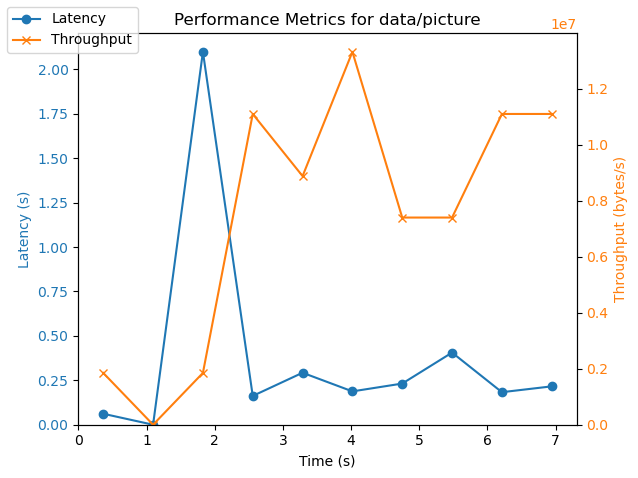

Latency List for data/picture: [0.0682532787322998, 0.057756662368774414, 0.05811047554016113, 0.05811047554016113, 0.05811047554016113, 0.06907129287719727, 0.0700831413269043, 0.059122323989868164, 0.059122323989868164, 0.059122323989868164, 2.0713751316070557, 2.0783615112304688, 2.0793588161468506, 2.085770845413208, 2.096362352371216, 2.101851463317871, 2.1161699295043945, 2.1173007488250732, 2.108337163925171, 2.1263792514801025, 0.12128043174743652, 0.12029910087585449, 0.12745451927185059, 0.13841724395751953, 0.1472630500793457, 0.14925813674926758, 0.1441810131072998, 0.14869379997253418, 0.14835429191589355, 0.15088152885437012, 0.15283775329589844, 0.15700030326843262, 0.15890979766845703, 0.16143155097961426, 0.1624290943145752, 0.15990829467773438, 0.1633899211883545, 0.1644001007080078, 0.16539812088012695, 0.17001771926879883, 0.19617223739624023, 0.19776201248168945, 0.20016908645629883, 0.20016813278198242, 0.19917082786560059, 0.19917082786560059, 0.19999337196350098

In [4]:
async def main():
    try:
        async with aiohttp.ClientSession() as session:
            # 1. Get Anton's connections and delete them
            anton_connections_url = f"{anton_base_url}/connections"
            anton_connections_response = await fetch_connections(session, anton_connections_url)
            anton_connections = anton_connections_response["results"]
            
            delete_tasks = []
            for connection in anton_connections:
                connection_id = connection["connection_id"]
                delete_url = f"{anton_base_url}/connections/{connection_id}"
                delete_tasks.append(delete_connection(session, delete_url))
            
            # Await all delete tasks
            await asyncio.gather(*delete_tasks)
        
            # 2. Get Bob's connections
            bob_connections_url = f"{bob_base_url}/connections"
            bob_connections_response = await fetch_connections(session, bob_connections_url)
        
            # 3. Bob sends a connection request to Anton
            bob_create_request_url = f"{bob_base_url}/didexchange/create-request?their_public_did=NyaE9SFSneSNRq6Ch8N9Pt&alias=Anton"
            bob_create_request_response = await create_request(session, bob_create_request_url)
            #bob_connection_id = bob_create_request_response["connection_id"]
        
            # Wait for the connection request to appear in Anton's connections
            await asyncio.sleep(2) 
        
            # 4. query again (if in different machines, ignore all step 1-3)
            anton_connections_url = f"{anton_base_url}/connections"
            anton_connections_response = await fetch_connections(session, anton_connections_url)
            anton_connections = anton_connections_response["results"]

            bob_connection_id = bob_connection_id = anton_connections[0]["connection_id"]

            # 5. Anton sends a message to Bob
            send_message_url = f"{anton_base_url}/connections/{bob_connection_id}/send-message"

            test_cases = [
                #('data/text', 50, 10, 'data/performance/test_text_http1_50_10_0ms.sh'),
                ('data/picture', 20, 20, 'data/performance/test_picture_http1_50_10_0ms.sh'),
                #('data/video', 20, 5, 'data/performance/test_video_http1_20_5_0ms.sh'),
            ]

            for data_folder, parallel_count, num_repeats, route in test_cases:
                await test_performance(send_message_url, data_folder, parallel_count, num_repeats, route)
    except KeyboardInterrupt:
        print("Process interrupted by user")

# Run the main function
try:
    asyncio.run(main())
except KeyboardInterrupt:
    print("Process interrupted by user")

